## BEA API with Python

January 2026

---

Example of using the BEA API to calculate consumer spending growth by major category of goods. 

BEA API Documentation can be found [here](https://www.bea.gov/resources/for-developers). Register to obtain an API key.

The python requests and pandas packages are used.

In [41]:
import requests
import pandas as pd
from config import bea_key as api_key   ## File with API key

### Example 1: Fetch NIPA Table
This example requests NIPA table 2.3.6 for the latest five years.

In [43]:
# Components of request
base = f'https://apps.bea.gov/api/data/?&UserID={config.bea_key}'
dset = '&method=GetData&datasetname=NIPA'
tbl = 'T20306' # Real PCE by Major Type of Product: NIPA Table 2.3.6.
freq = '&Frequency=Q'
yr = ','.join(map(str, range(2021, 2026)))
fmt = '&ResultFormat=json'
url = f'{base}{dset}&TableName={tbl}{freq}&Year={yr}{fmt}'

In [44]:
# Request data
r = requests.get(url)

Read the data using pandas. The API returns json format data, as requested. Python converts this data to a dictionary, which can be navigated using the dictionary keys. 

These data include thousands separators, which are removed. The `TimePeriod` column is converted to datetime. 

Next, consumer spending growth is calculated as `pce`, and the contribution from three categories to this growth is calculated as `res`.

In [109]:
# Read as pandas dataframe and organize
df = pd.DataFrame(r.json()['BEAAPI']['Results']['Data'])
df['Value'] = df.DataValue.str.replace(',','').astype('float')
df['Date'] = pd.to_datetime(df.TimePeriod, format='mixed')
data = df.set_index(['Date', 'SeriesCode'])['Value'].unstack()
pce = (((data['DPCERX'].pct_change() + 1) ** 4) - 1) * 100

s = {'DSERRX': 'Services', 'DNDGRX': 'Nondurable Goods',
     'DDURRX': 'Durable Goods'}
res = (data[s.keys()].diff().div(data['DPCERX'].diff(), axis=0)
              .multiply(pce, axis=0).dropna()
              .loc['2022':].rename(s, axis=1))
res.index.name = ''

A stacked bar chart helps visualize the results. 

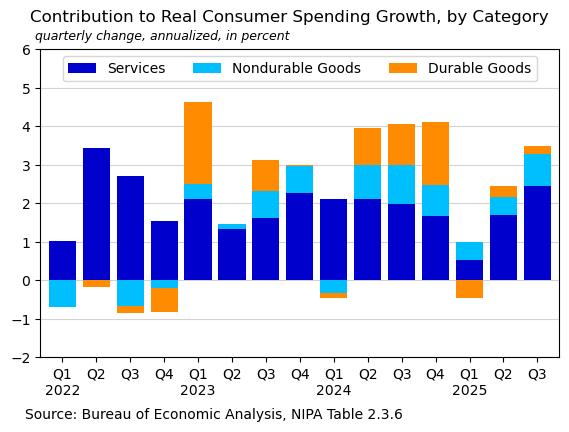

In [164]:
# Create chart
ax = (res.plot(kind='bar', stacked=True, figsize=(6.7, 4), 
               rot=0, color=['mediumblue', 'deepskyblue', 'darkorange'], 
               width=0.8, zorder=3))
ax.legend(ncols=3, loc='upper center')
ax.set_ylim(-2, 6)
ax.axhline(0, lw=0.5, color='gray', zorder=0)
ax.grid(axis='y', zorder=0, color='lightgray')
ax.set_xticklabels([f'Q1\n{i.year}' if i.month == 1 else f'Q{(i.month+2)/3:.0f}' 
                    for i in res.index])
title = 'Contribution to Real Consumer Spending Growth, by Category'
subtitle = 'quarterly change, annualized, in percent'
ax.text(-0.02, 1.09, title, transform=ax.transAxes, fontsize=12);
ax.text(-0.01, 1.03, subtitle, transform=ax.transAxes, fontsize=9, style='italic');
footer = 'Source: Bureau of Economic Analysis, NIPA Table 2.3.6'
ax.text(-0.03, -0.2, footer, transform=ax.transAxes, fontsize=10);

### Example 2: Collect API Parameters 

Next, we navigate through metadata returned by the API and use these metadata to create a request. Using the metadata, we can find the codes for the table we want. Only the first five rows are shown to save space, but table `25`, Composition of Gross Output, is what we want for this example.

In [186]:
# Components of request
base = f'https://apps.bea.gov/api/data/?&UserID={api_key}'
get_param = '&method=GetParameterValues'
dataset = '&DataSetName=GDPbyIndustry'
param = 'TableID'

# Construct URL from parameters above
url = f'{base}{get_param}{dataset}&ParameterName={param}&ResultFormat=json'

# Request parameter information from BEA API
r = requests.get(url)

# Show the results as a table:
pd.DataFrame(r.json()['BEAAPI']['Results']['ParamValue']).set_index('Key').head()

,Desc
Key,
1,Value Added by Industry (A) (Q)
5,Value added by Industry as a Percentage of Gro...
6,Components of Value Added by Industry (A)
7,Components of Value Added by Industry as a Per...
8,Chain-Type Quantity Indexes for Value Added by...


Fetch list of industry codes and descriptions. In this case, we want industry code `23` for the Construction industry.

In [188]:
param = 'Industry'

# Construct URL from parameters above
url = f'{base}{get_param}{dataset}&ParameterName={param}&ResultFormat=json'

# Request parameter information from BEA API
r = requests.get(url).json()

# Show the results as a table:
pd.DataFrame(r['BEAAPI']['Results']['ParamValue']).set_index('Key').head(10)

,Desc
Key,
11,"Agriculture, forestry, fishing, and hunting (A,Q)"
111CA,"Farms (A,Q)"
113FF,"Forestry, fishing, and related activities (A,Q)"
21,"Mining (A,Q)"
211,"Oil and gas extraction (A,Q)"
212,"Mining, except oil and gas (A,Q)"
213,"Support activities for mining (A,Q)"
22,"Utilities (A,Q)"
23,"Construction (A,Q)"


Using the parameters obtained above, we fetch table `25` for industry `23`. The results are cleaned up as a pandas dataframe.

In [191]:
m = '&method=GetData'
ind = '&TableId=25'
freq = '&Frequency=A'
year = '&Year=ALL'
fmt = '&ResultFormat=json'
indus = '&Industry=23'  # Construction Industry

# Combined url for request
url = f'{base}{m}{dataset}{year}{indus}{ind}{freq}{fmt}'

r = requests.get(url)

df = pd.DataFrame(r.json()['BEAAPI']['Results'][0]['Data'])
df = df.replace('Construction', 'Gross Output')
df = df.set_index([pd.to_datetime(df['Year']), 
                   'IndustrYDescription'])['DataValue'].unstack(1)
df = df.apply(pd.to_numeric)
df.tail()

IndustrYDescription,Compensation of employees,Energy inputs,Gross Output,Gross operating surplus,Intermediate inputs,Materials inputs,Purchased-services inputs,Taxes on production and imports less subsidies,Value added
Year,,,,,,,,,
2020-01-01,597.8,30.3,1804.4,415.3,845.7,636.6,178.8,-54.4,958.7
2021-01-01,636.9,45.7,1985.6,400.8,973.5,749.7,178.1,-25.6,1012.1
2022-01-01,694.3,50.9,2204.0,404.5,1091.6,840.5,200.3,13.6,1112.4
2023-01-01,745.0,51.0,2389.0,465.4,1164.5,854.9,258.6,14.1,1224.6
2024-01-01,799.3,45.4,2511.5,491.2,1206.1,869.9,290.7,14.9,1305.4


Last, a chart is created to visualize the labor income share of value added.

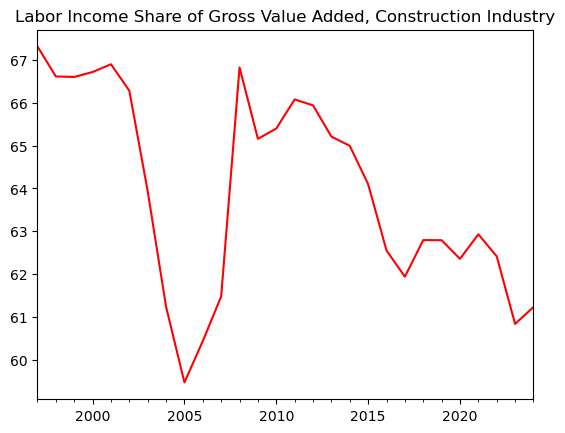

In [179]:
# Labor income share of industry value added
data = (df['Compensation of employees'] / df['Value added']) * 100
data.index.name = ''
title = 'Labor Income Share of Gross Value Added, Construction Industry'
ax = data.plot(color='red', title=title);